### Library Import

In [51]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go


### Data Load

In [52]:
# 파일 호출
data_path: str = "/data/ephemeral/home/BTC/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [53]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:03<00:00, 35.11it/s]


In [54]:
eda_df = df.loc[df["_type"] == "train"]
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 8759
Columns: 255 entries, ID to hourly_market-data_open-interest_okx_btc_usdt_open_interest
dtypes: float64(250), int64(3), object(2)
memory usage: 17.1+ MB


In [55]:
eda_df = df.loc[df["_type"] == "train"]
# column 추출
# taker_buy_sell_volume: ratio data 제외
# fees: total 제외
# tokens-transferred, transactions-count: total 제외
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "close",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume": "volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "taker_buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "taker_sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "addresses_count_active",
    "hourly_network-data_addresses-count_addresses_count_sender": "addresses_count_sender",
    "hourly_network-data_addresses-count_addresses_count_receiver": "addresses_count_receiver",
    "hourly_network-data_block-bytes_block_bytes": "block_bytes",
    "hourly_network-data_block-count_block_count": "block_count",
    "hourly_network-data_block-interval_block_interval": "block_interval",
    "hourly_network-data_blockreward_blockreward": "blockreward",
    "hourly_network-data_blockreward_blockreward_usd": "blockreward_usd",
    "hourly_network-data_difficulty_difficulty": "difficulty",
    "hourly_network-data_fees_fees_block_mean": "fees_block_mean",
    "hourly_network-data_fees_fees_block_mean_usd": "fees_block_mean_usd",
    "hourly_network-data_fees-transaction_fees_transaction_mean": "fees_transaction_mean",
    "hourly_network-data_fees-transaction_fees_transaction_mean_usd": "fees_transaction_mean_usd",
    "hourly_network-data_fees-transaction_fees_transaction_median": "fees_transaction_median",
    "hourly_network-data_fees-transaction_fees_transaction_median_usd": "fees_transaction_median_usd",
    "hourly_network-data_hashrate_hashrate": "hashrate",
    "hourly_network-data_supply_supply_total": "supply_total",
    "hourly_network-data_supply_supply_new": "supply_new",
    "hourly_network-data_tokens-transferred_tokens_transferred_mean": "tokens_transferred_mean",
    "hourly_network-data_tokens-transferred_tokens_transferred_median": "tokens_transferred_median",
    "hourly_network-data_transactions-count_transactions_count_mean": "transactions_count_mean",
    "hourly_network-data_utxo-count_utxo_count": "utxo_count",
    "hourly_network-data_velocity_velocity_supply_total": "velocity_supply_total"
}
# 추출후 단순화를 위해 rename
eda_df = eda_df[cols_dict.keys()].rename(cols_dict, axis=1)

In [56]:

eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 8759
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           8760 non-null   object 
 1   target                       8760 non-null   float64
 2   coinbase_premium_gap         8755 non-null   float64
 3   coinbase_premium_index       8755 non-null   float64
 4   long_liquidations            8760 non-null   float64
 5   short_liquidations           8760 non-null   float64
 6   long_liquidations_usd        8760 non-null   float64
 7   short_liquidations_usd       8760 non-null   float64
 8   open_interest                8760 non-null   float64
 9   close                        8760 non-null   float64
 10  volume                       8760 non-null   float64
 11  taker_buy_volume             8760 non-null   float64
 12  taker_sell_volume            8760 non-null   float64
 13  addresses_count_active 

### EDA (Explanatory Data Analysis)

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#### 결측치 확인

In [58]:
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

fees_transaction_mean_usd      0.216895
tokens_transferred_mean        0.216895
block_interval                 0.216895
block_bytes                    0.216895
transactions_count_mean        0.216895
fees_block_mean_usd            0.216895
fees_block_mean                0.216895
difficulty                     0.216895
fees_transaction_mean          0.216895
coinbase_premium_index         0.057078
coinbase_premium_gap           0.057078
target                         0.000000
ID                             0.000000
taker_buy_volume               0.000000
long_liquidations              0.000000
short_liquidations             0.000000
open_interest                  0.000000
close                          0.000000
long_liquidations_usd          0.000000
short_liquidations_usd         0.000000
blockreward                    0.000000
block_count                    0.000000
addresses_count_sender         0.000000
addresses_count_receiver       0.000000
addresses_count_active         0.000000


#### close(종가)와 상관관계가 높은 변수

In [59]:
# close와 상관관계가 높은 feature 순으로 출력
eda_df.drop(columns='ID', inplace=False).corr()['close'].sort_values(ascending =False).head(20)

close                          1.000000
open_interest                  0.889183
difficulty                     0.882241
supply_total                   0.806199
utxo_count                     0.763803
fees_transaction_median_usd    0.621048
fees_transaction_mean_usd      0.554984
fees_block_mean_usd            0.551055
fees_transaction_median        0.545186
blockreward_usd                0.537638
transactions_count_mean        0.489279
fees_block_mean                0.484006
fees_transaction_mean          0.466886
hashrate                       0.339524
blockreward                    0.123338
addresses_count_sender         0.119106
block_bytes                    0.075970
taker_sell_volume              0.039590
taker_buy_volume               0.037201
short_liquidations_usd         0.028132
Name: close, dtype: float64

close 변동과 상관관계가 높은 feature(상관계수 0.6 이상) 선정

In [60]:
close_selected = ['close', 'open_interest', 'difficulty', 'supply_total', 'utxo_count', 'fees_transaction_median_usd']

##### close와 close_selected 관계 확인을 위한 시각화

1. 시계열 데이터 시각화 : 시간에 따른 close와 close_selected 변동을 시각화하여 패턴을 확인

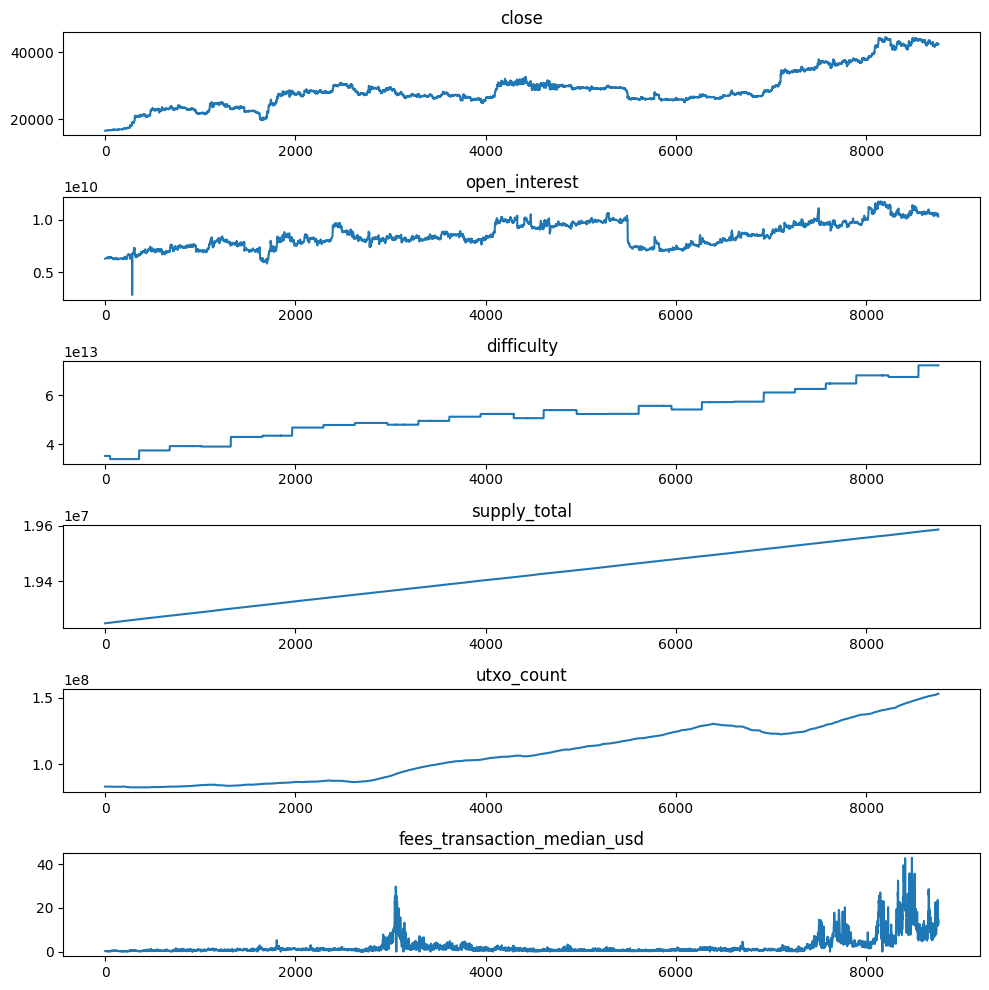

In [61]:
fig2, axes = plt.subplots(len(close_selected), 1, figsize=(10, 10))
for i, feature in enumerate(close_selected):
    eda_df[feature].plot(ax=axes[i], title=feature)
plt.tight_layout()

plt.show()

- close와 (fees_transaction_median_usd를 제외한 나머지 변수들은 시간이 지남에 따라 비슷한 증가 패턴을 보인다.

In [62]:
close_selected.remove('fees_transaction_median_usd')

- open_interest는 시간이 지남에 따라 두드러지게 비슷한 패턴을 보인다.

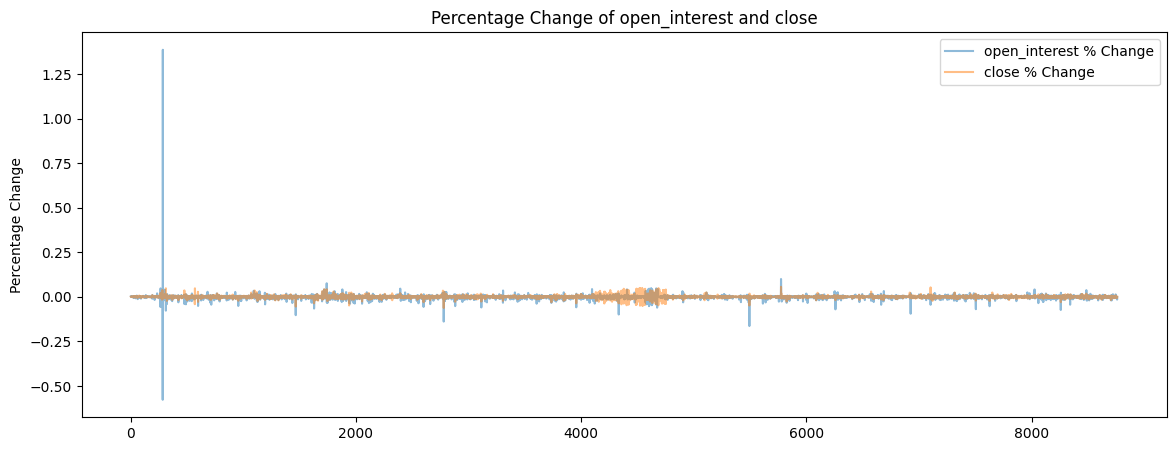

In [117]:
# 퍼센트 변화율을 시각화
eda_df['open_interest_pct_change'] = eda_df['open_interest'].pct_change()
eda_df['close_pct_change'] = eda_df['close'].pct_change()

plt.figure(figsize=(14, 5))
plt.plot(eda_df['open_interest_pct_change'], label='open_interest % Change', alpha=0.5)
plt.plot(eda_df['close_pct_change'], label='close % Change', alpha=0.5)
plt.legend()
plt.title('Percentage Change of open_interest and close')
plt.ylabel('Percentage Change')
plt.show()

**[ 가설 ]**
- open_interest가 증가하면, 시장에 더 많은 자본이 유입되고 있음을 나타낼 수 있으며, 이는 종가 상승에 기여할 수 있다.
    
    *시장에 자본이 유입되었다 = 코인의 수요가 증가했다 = 종가 상승*
- open_interest의 변화량은 close의 변화량에 유의미한 영향을 미친다.

##### close_selected간 상관관계 분석

1. closed_selected간 관계 시각화

In [70]:
close_selected.remove('close')

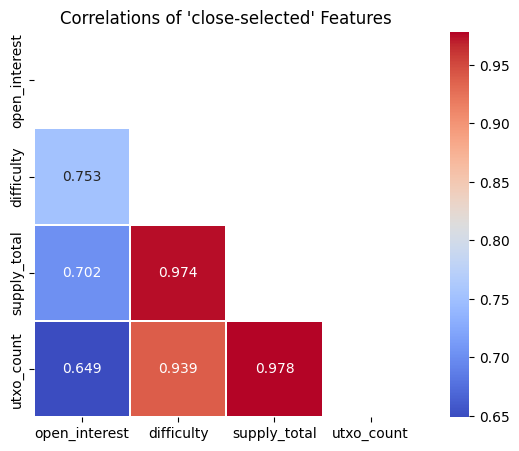

In [71]:
close_corr_df = eda_df[close_selected].corr()

# 히트맵으로 시각화
mask = np.zeros_like(close_corr_df)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8, 5))
sns.heatmap(close_corr_df, cmap='coolwarm', annot=True, fmt='.3f', linewidth=0.2, square=True, mask=mask)
plt.title('Correlations of \'close-selected\' Features')
plt.show()

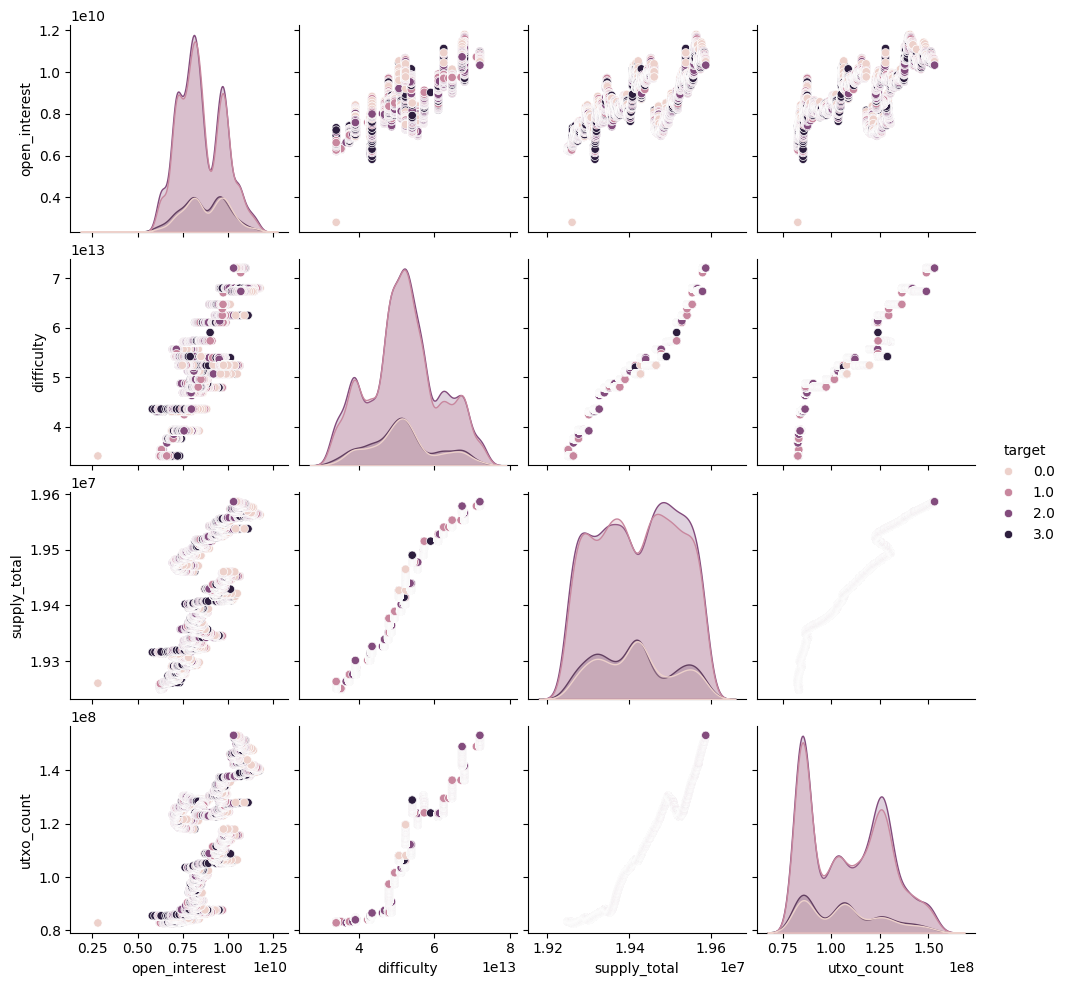

In [90]:
sns.pairplot(eda_df[close_selected + ['target']], hue='target')
plt.show()

2. 변수 간 조합 생성

    시각화에서 모든 변수가 서로 높은 양의 상관관계가 있다는 사실은 알아냈지만,

    어떤 변수 간 조합을 해야 할 지에 대해 명확하지 않아 도메인 지식을 더해 변수를 생성하고 유의미한 지 파악한다.

In [119]:
# 변수 생성
eda_df['open_interest_ratio'] = eda_df['open_interest'] / eda_df['supply_total'] * 100
eda_df['utxo_count_ratio'] = eda_df['utxo_count'] / eda_df['supply_total']
eda_df['open_interest_index'] = (eda_df['open_interest'] * eda_df['difficulty']) / eda_df['supply_total']

close_interactions = [
    'close', 'open_interest', 'open_interest_ratio', 'utxo_count_ratio', 'open_interest_index'
]

1. open_interest / supply_total * 100
    
    시장의 관심도를 더 직관적으로 이해할 수 있다.
    
    이 값이 높다면, 시장의 관심이 총 공급량 대비 매우 높음을 나타낼 수 있다. (수요가 공급보다 높다)
2. utxo_count / supply_total
    
    네트워크의 유동성을 나타낼 수 있다.
    
    이 비율이 높다면, 많은 비트코인이 거래되지 않고 보유되고 있는 상황을 나타낼 수 있다.
3. (open_interest * difficulty) / supply_total
    
    시장의 관심도와 채굴의 어려움을 총 공급량 대비하여 나타낼 수 있다.
    
    이는 시장의 과열 여부를 판단하는 데 도움이 될 수 있다.

3. 변수 간 조합 시각화

In [120]:
# close와 상관관계가 높은 feature 순으로 출력
eda_df[close_interactions].corr()['close'].sort_values(ascending =False)

close                  1.000000
open_interest_index    0.956706
open_interest          0.889183
open_interest_ratio    0.881836
utxo_count_ratio       0.761479
Name: close, dtype: float64

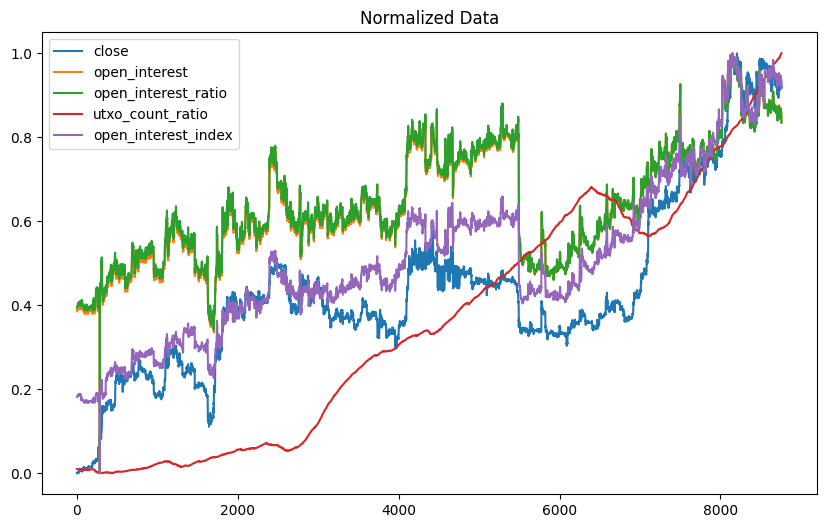

In [131]:
# 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(eda_df[close_interactions])
scaled_close_interactions_df = pd.DataFrame(scaled_data, columns=close_interactions)

plt.figure(figsize=(10, 6))
for feature in close_interactions:
    plt.plot(scaled_close_interactions_df[feature], label=feature)

plt.legend()
plt.title('Normalized Data')
plt.show()

- open_interest_index 가 가격을 예측하는 데 가장 유의미한 변수
- open_interest_index 조합에 다른 변수들을 추가로 조합하면 라인 차트의 양상이 더욱 비슷해질 것으로 예상